In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import skimage.transform
import skimage.io
import numpy as np
from sklearn.cluster import KMeans
import random
from PIL import Image
from PIL import ImageFont

import scipy.misc
from PIL import ImageDraw 

In [2]:

def try_composite(a, d, n, s):
    # test the base a to see whether it is a witness for the compositeness of n
    if pow(a, d, n) == 1:
        return False
    for i in range(s):
        if pow(a, 2**i * d, n) == n-1:
            return False
    return True # n is definitely composite

    
def is_probable_prime(n, mrpt_num_trials = 5):
    """
    Miller-Rabin primality test.
 
    A return value of False means n is certainly not prime. A return value of
    True means n is very likely a prime.
 
    >>> is_probable_prime(1)
    Traceback (most recent call last):
        ...
    AssertionError
    >>> is_probable_prime(2)
    True
    >>> is_probable_prime(3)
    True
    >>> is_probable_prime(4)
    False
    >>> is_probable_prime(5)
    True
    >>> is_probable_prime(123456789)
    False
 
    >>> primes_under_1000 = [i for i in range(2, 1000) if is_probable_prime(i)]
    >>> len(primes_under_1000)
    168
    >>> primes_under_1000[-10:]
    [937, 941, 947, 953, 967, 971, 977, 983, 991, 997]
 
    >>> is_probable_prime(6438080068035544392301298549614926991513861075340134\
3291807343952413826484237063006136971539473913409092293733259038472039\
7133335969549256322620979036686633213903952966175107096769180017646161\
851573147596390153)
    True
 
    >>> is_probable_prime(7438080068035544392301298549614926991513861075340134\
3291807343952413826484237063006136971539473913409092293733259038472039\
7133335969549256322620979036686633213903952966175107096769180017646161\
851573147596390153)
    False
    """
    assert n >= 2
    # special case 2
    if n == 2:
        return True
    # ensure n is odd
    if n % 2 == 0:
        return False
    # write n-1 as 2**s * d
    # repeatedly try to divide n-1 by 2
    s = 0
    d = n-1
    while True:
        quotient, remainder = divmod(d, 2)
        if remainder == 1:
            break
        s += 1
        d = quotient
    assert(2**s * d == n-1)
                                     
    for i in range(mrpt_num_trials):
        a = random.randrange(2, n)
        if try_composite(a, d, n, s):
            return False
        

 
    return True # no base tested showed n as composite


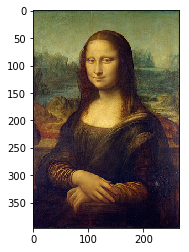

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [3]:
def get_k_means(image):
    image = np.reshape(image, (-1, 3))
    kmeans = KMeans(n_clusters=10).fit(image)
    return kmeans


# def get_compressed_image(image):
#     orig_shape = image.shape
#     image = np.reshape(image, (-1, 3))
#     kmeans = KMeans(n_clusters=10).fit(image)

#     new_image = np.zeros(image.shape)
#     prime_image = np.zeros(image.shape[0], dtype=np.uint8)
    
#     for label, center in zip(range(10), kmeans.cluster_centers_):
#         new_image[kmeans.labels_==label] = center
#         prime_image[kmeans.labels_==label] = label
#     new_image = np.reshape(new_image, orig_shape)
#     prime_image = np.reshape(prime_image, orig_shape[:2])
#     return new_image, prime_image, kmeans


def load_image(filename):
    image = skimage.io.imread(filename)
    image = image.astype(np.float64)
    image = image / 255.
    return image

image = load_image('input_pictures/monalisa.jpg')
plt.imshow(image)
plt.show()


oldshape = image.shape
resized_image = skimage.transform.resize(image, (oldshape[0]//16, oldshape[1]//16))
# new_image, prime_image, kmeans = get_compressed_image(resized_image)
# plt.imshow(new_image)
# plt.show()
# print(new_image.shape)



In [4]:

def create_numbered_image(image, kmeans):
    # apply noise
    stdev = np.std(image)
    random_noise = np.random.random_sample(size=image.shape)*(stdev/3)
    image = image + random_noise
    
    orig_shape = image.shape
    image = np.reshape(image, (-1, 3))

    numbered_image = kmeans.predict(image)
    numbered_image = np.reshape(numbered_image, orig_shape[:2])
    
    assert numbered_image.shape[0] < 50 and "WATCH OUT FOR THE HEIGHT OF IMAGES"
    assert numbered_image.shape[1] < 50 and "WATCH OUT FOR THE WIDTH OF IMAGES"
    
    # make sure the end is uneven
    if numbered_image[-1,-1]%2==0:
        numbered_image[-1,-1] += 1

    return numbered_image

def numbered_image_to_normal_image(numbered_image, kmeans):
    shape = (numbered_image.shape[0], numbered_image.shape[1], 3)
    image = np.zeros(shape)
    for label, color in zip(range(10), kmeans.cluster_centers_):
        image[numbered_image==label] = color
    return image



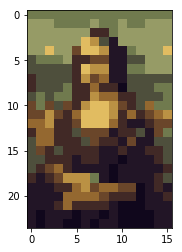

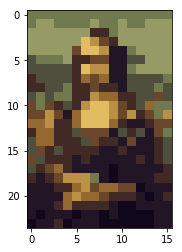

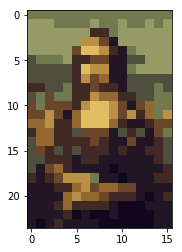

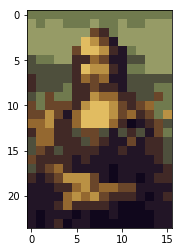

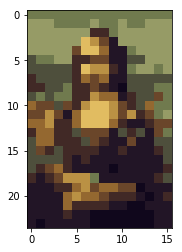

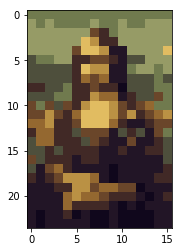

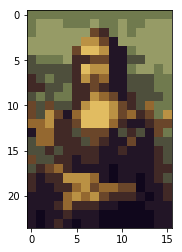

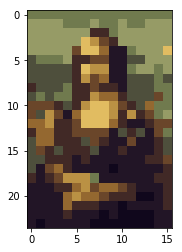

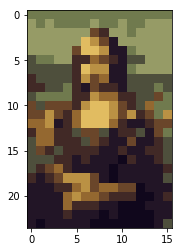

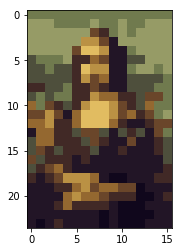

In [5]:
kmeans = get_k_means(resized_image)
for _ in range(10):
    n_image = create_numbered_image(resized_image, kmeans)
    normal_image = numbered_image_to_normal_image(n_image, kmeans)
    
    plt.imshow(normal_image)
    plt.show()

In [6]:

def image_to_number(numbered_image):
    to_be_number = numbered_image.reshape(-1)
    as_string = ''.join([str(int(x)) for x in to_be_number])
    as_int = int(as_string)
    return as_int, as_string


In [7]:

def show_and_save_image(image, n_image, filename, fontsize=16):
    oldshape = image.shape
    resized_image= scipy.misc.imresize(image,(oldshape[0]*fontsize, oldshape[1]*fontsize), interp='nearest')
    img = Image.fromarray(resized_image).convert("RGBA")
    txt = Image.new('RGBA', img.size, (255,255,255,0))

    draw = ImageDraw.Draw(txt)
    font = ImageFont.truetype("pirulen rg.ttf", fontsize)
    for y_i, totype in enumerate(n_image):
        for x_i, letter in enumerate(totype):
            xpos = x_i * fontsize + 1
            ypos = y_i * fontsize
            if letter == 1:
                xpos += 4
            draw.text((xpos, ypos),str(letter),(255,255,255, 128),font=font)
    img = Image.alpha_composite(img, txt)    

    img.save(filename)
    plt.figure(figsize=(20,20))
    plt.imshow(img)
    plt.show()


In [8]:
def result_filename(filename):
    return filename.split('.')[0] + "-prime.png"

def is_good_prime_portrait(n_image):
    integer, string = image_to_number(n_image)
    
    if is_probable_prime(integer): 
        return integer, string, n_image
    else:
        return None

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Working with size (23, 18, 3)
----------------------------------------------------------------------------------------------------
333333813441331131333111134744131111333330468467111313333367741447331333136374441348041113005234474368703183569453420055453500354933077742240464351666834292355363335504408228105533331045623144452033333444440604506533333338040644415133333356042447431333333381664447131333331833644406626133333633504552245333333113605050003333113333685155331131055550511888005050555500018181050500555000008880000000000000000000000001
----------------------------------------------------------------------------------------------------
333333813441331131
333111134744131111
333330468467111313
333367741447331333
136374441348041113
005234474368703183
569453420055453500
354933077742240464
351666834292355363
335504408228105533
331045623144452033
333444440604506533
333338040644415133
333356042447431333
333381664447131333
331833644406626133
333633504552245333
333113605050003333
11333368515

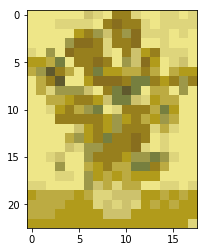

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/misc/pilutil.py:480: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/misc/pilutil.py:483: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


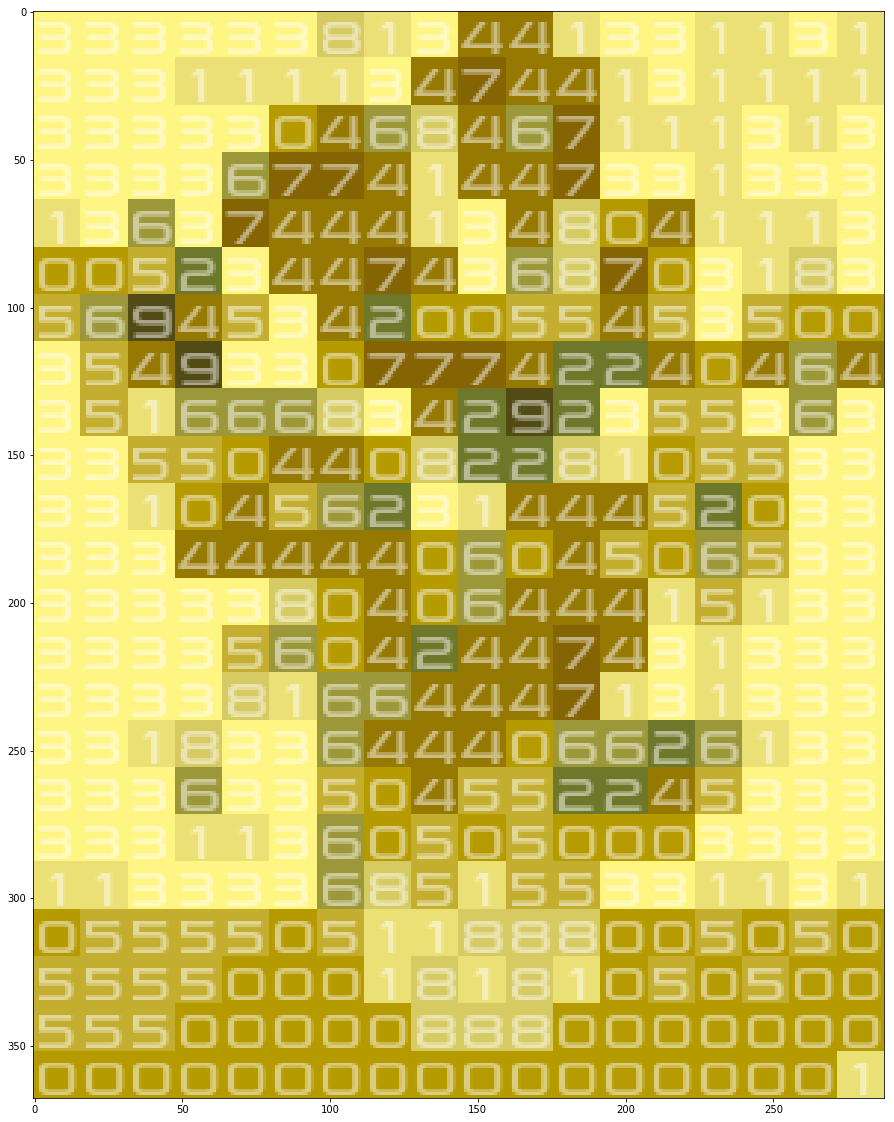

In [9]:
folder = 'input_pictures/'

filenames = [
     folder + 'sunflowers.jpg',
]

for filename in filenames:
    image = load_image(filename)
    oldshape = image.shape
    resized_image = skimage.transform.resize(image, (oldshape[0]//16, oldshape[1]//16))
    print("Working with size " + str(resized_image.shape))
#     new_image, prime_image, kmeans = get_compressed_image(resized_image)
    kmeans = get_k_means(resized_image)
#     plt.imshow(new_image)
#     plt.show()
    
    
    for _ in range(10000):
        n_image = create_numbered_image(resized_image, kmeans)    
        
        result = is_good_prime_portrait(n_image)
        if result != None:
            integer, string, n_image = result
            print("-"*100)
            print(string)
            print("-"*100)
            for line in n_image:
                print(''.join([str(x) for x in line]))
            normal_image = numbered_image_to_normal_image(n_image, kmeans)
            plt.imshow(normal_image)
            plt.show()
            show_and_save_image(normal_image, n_image, result_filename(filename))
            break

## Multi threaded attempt


In [10]:
from multiprocessing.dummy import Pool as ThreadPool 
pool = ThreadPool(8) 

def prepare_image(filename):    
    image = load_image(filename)
    oldshape = image.shape
    resized_image = skimage.transform.resize(image, (oldshape[0]//8, oldshape[1]//8))
    print("Working with size " + str(resized_image.shape))
#     new_image, prime_image, kmeans = get_compressed_image(resized_image)
    kmeans = get_k_means(resized_image)

prepare_image(filenames[0])

import time
start = time.clock() 


image_generator = (create_numbered_image(resized_image, kmeans) for _ in range(100000))

results = pool.imap_unordered(is_good_prime_portrait, image_generator)
total_results = 0
for result in results:
    total_results += 1
    if total_results%10==0:
        elapsed = time.clock()
        elapsed = elapsed - start
        print("Time spent in (function name) is {} time per result: {}".format(str(elapsed), str(elapsed/total_results)))
        
    if result != None:
        integer, string, n_image = result
        
        print("-"*100)
        print(string)
        print("-"*100)
        for line in n_image:
            print(''.join([str(x) for x in line]))
        normal_image = numbered_image_to_normal_image(n_image, kmeans)
        plt.imshow(normal_image)
        plt.show()
        show_and_save_image(normal_image, n_image, result_filename(filename))
        break


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Working with size (47, 37, 3)


NameError: name 'get_compressed_image' is not defined

## How does this scale

Appartenlty the largest known prime number is 22338618 long (http://primes.utm.edu/largest.html). This would allow us to create a 4726 * 4726 prime portrait, which means that prime portraits in 4K resolution are viable :D



In [ ]:
def trials_needed_img(w,h):
    return 2.3*w*h

needed = [trials_needed_img(x,x) for x in range(1,300)]
plt.plot(needed)

## Can we create a prime movie? 
The Solitude of Prime Numbers - Wikipedia